# DATA PREP

In [37]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# your dataset folder directory
data_dir = "Dataset"

# define the 4 training directories class
glasses_training_dir = os.path.join(data_dir, "Images", "glasses")
no_training_dir = os.path.join(data_dir, "Images", "no_glasses")

# create a list of image file paths and labels
image_files = []
labels = []

# Load image file paths and corresponding labels
for class_name, class_dir in [("glasses", glasses_training_dir), ("no_glasses", no_training_dir)]:
    for filename in os.listdir(class_dir):
        image_files.append(os.path.join(class_dir, filename))
        labels.append(class_name)

# Create a Pandas DataFrame
df = pd.DataFrame(list(zip(image_files, labels)), columns=['filename', 'label'])

# Define the percentage of data for validation
validation_split = 0.2

# Split the data into training and validation sets
train_df = df.sample(frac=1 - validation_split, random_state=1)
val_df = df.drop(train_df.index)

# Define ImageDataGenerator for training
training_datagen = ImageDataGenerator(rescale=1./255)
training_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = training_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='label',
    target_size=(256, 256),
    class_mode='binary',
    batch_size=16
)

# Define ImageDataGenerator for validation
validation_datagen = ImageDataGenerator(rescale=1./255)
val_generator = validation_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='label',
    target_size=(256, 256),
    class_mode='binary',
    batch_size=16
)

# Print the number of samples in the training and validation sets
print("Jumlah sampel data pelatihan:", len(train_df))
print("Jumlah sampel data validasi:", len(val_df))


Found 3936 validated image filenames belonging to 2 classes.
Found 984 validated image filenames belonging to 2 classes.
Jumlah sampel data pelatihan: 3936
Jumlah sampel data validasi: 984


# CREATE MODEL

In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.25),
    Dense(1, activation='sigmoid')
])


In [58]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_33 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 62, 62, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_34 (Conv2D)          (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 30, 30, 128)      

In [59]:
model.compile(loss = 'binary_crossentropy', optimizer=RMSprop(learning_rate=0.001), metrics=['accuracy'])

In [60]:
from tensorflow.keras.callbacks import EarlyStopping

# Callback untuk menghentikan pelatihan jika akurasi lebih dari 0.95
custom_callback = EarlyStopping(
    monitor='accuracy',  # Menyimak metrik akurasi pelatihan
    baseline=0.95,  # Hentikan pelatihan jika akurasi mencapai atau melebihi 0.95
    mode='max',  # Mode 'max' berarti akan berhenti jika metrik mencapai nilai maksimum
    patience=20,  # Bersabar selama 3 epoch jika kondisi tidak terpenuhi
    verbose=1,  # Tampilkan pesan verbose
    restore_best_weights=True  # Kembalikan bobot terbaik saat pelatihan dihentikan
)

# Callback untuk menghentikan pelatihan jika val_accuracy lebih dari 0.95
custom_callback_val = EarlyStopping(
    monitor='val_accuracy',  # Menyimak metrik akurasi validasi
    baseline=0.95,  # Hentikan pelatihan jika val_accuracy mencapai atau melebihi 0.95
    mode='max',  # Mode 'max' berarti akan berhenti jika metrik mencapai nilai maksimum
    patience=20,  # Bersabar selama 3 epoch jika kondisi tidak terpenuhi
    verbose=1,  # Tampilkan pesan verbose
    restore_best_weights=True  # Kembalikan bobot terbaik saat pelatihan dihentikan
)




In [61]:
history = model.fit(
      train_generator,
      steps_per_epoch=20,  
      epochs=20,
      verbose=1,
      validation_data = val_generator,
      validation_steps=20,
      callbacks=[custom_callback, custom_callback_val]
)

Epoch 1/20
20/20 [==============================] - 113s 5s/step - loss: 1.1476 - accuracy: 0.5406 - val_loss: 0.6901 - val_accuracy: 0.5437
Epoch 2/20
20/20 [==============================] - 109s 5s/step - loss: 0.6952 - accuracy: 0.5688 - val_loss: 0.6796 - val_accuracy: 0.5688
Epoch 3/20
20/20 [==============================] - 110s 5s/step - loss: 0.7169 - accuracy: 0.5281 - val_loss: 0.6870 - val_accuracy: 0.5531
Epoch 4/20
20/20 [==============================] - 113s 5s/step - loss: 0.7468 - accuracy: 0.5312 - val_loss: 0.6815 - val_accuracy: 0.5469
Epoch 5/20
20/20 [==============================] - 162s 8s/step - loss: 0.7144 - accuracy: 0.5781 - val_loss: 0.6608 - val_accuracy: 0.5688
Epoch 6/20
20/20 [==============================] - 96s 5s/step - loss: 0.6738 - accuracy: 0.5688 - val_loss: 0.5169 - val_accuracy: 0.6812
Epoch 7/20
20/20 [==============================] - 147s 7s/step - loss: 0.5933 - accuracy: 0.6812 - val_loss: 0.6384 - val_accuracy: 0.5656
Epoch 8/20
20/

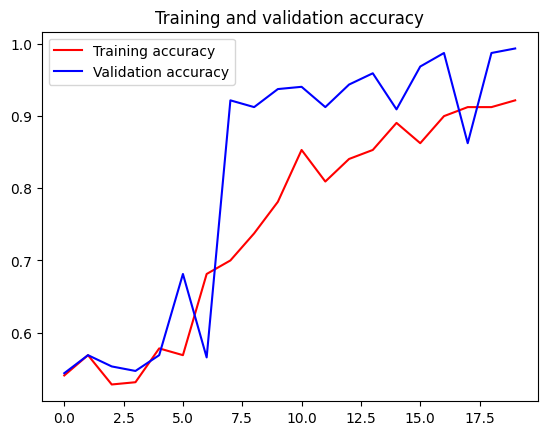

<Figure size 640x480 with 0 Axes>

In [62]:
import matplotlib.pyplot as plt

# Plot the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

# PREDICTING

In [69]:
import tkinter as tk
from tkinter import filedialog
from tkinter.filedialog import askopenfile
from PIL import Image, ImageTk
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np

#function to call the upload file dialog box
def upload_file():
    global img, predict_path
    f_types = [('Image Files', '*.jpg;*.jpeg;*.png')]
    filename = filedialog.askopenfilename(filetypes=f_types)
    predict_path = filename
    img = ImageTk.PhotoImage(file=filename)
    my_w.destroy()

my_w = tk.Tk()
my_w.geometry("400x300")  
my_w.title('upload your image')
my_font1=('times', 18, 'bold')
l1 = tk.Label(my_w,text='upload your image',width=30,font=my_font1)  
l1.grid(row=1,column=1)
b1 = tk.Button(my_w, text='Upload File', 
   width=20,command = lambda:upload_file())
b1.grid(row=2,column=1) 

my_w.mainloop()

img = load_img(predict_path, target_size=(256, 256))
x = img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)

# Load your model here (make sure you have it saved locally)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)
print(classes[0])



if classes[0] > 0.5:
    prediction = "no glasses!"
    print('no glasses')
else:
    prediction = "glasses!"
    print('glasses')


 

1/1 [==============================] - 0s 154ms/step
[0.00456074]
glasses


# SAVE MODEL

In [ ]:
model_path = "/tmp/model"

tf.saved_model.save(model, model_path)

In [ ]:
import pathlib
#TFLITE

def Tensolite(model_path, optm, filename="normal_model"):
  lite = tf.lite.TFLiteConverter
  lite_model = lite.from_saved_model(model_path)
  if optm:
    lite_model.optimizations = optm
  tflite_model = lite_model.convert()
  tflite_model_file = pathlib.Path(f"{filename}.tflite")
  tflite_model_file.write_bytes(tflite_model)
  return tflite_model

In [ ]:
optm = [tf.lite.Optimize.DEFAULT]

filemega = lambda filepath : os.path.getsize(filepath) / float(2**20)

tflite_model = Tensolite(model_path, optm=optm, filename="normal_model")

round(filemega("/content/normal_model.tflite"), 3)

In [ ]:
#MODEL H5
model.save("glasses.h5")